## Problem Statement_[Data Science for Good: Kiva Crowdfunding](https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding)
Kiva.org is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. For the locations in which Kiva has active loans, your objective is to pair Kiva's data with additional data sources to estimate the welfare level of borrowers in specific regions, based on shared economic and demographic characteristics.

A good solution would connect the features of each loan or product to one of several poverty mapping datasets, which indicate the average level of welfare in a region on as granular a level as possible. Many datasets indicate the poverty rate in a given area, with varying levels of granularity. Kiva would like to be able to disaggregate these regional averages by gender, sector, or borrowing behavior in order to estimate a Kiva borrower’s level of welfare using all of the relevant information about them. Strong submissions will attempt to map vaguely described locations to more accurate geocodes.

Kernels submitted will be evaluated based on the following criteria:

1. Localization - How well does a submission account for highly localized borrower situations? Leveraging a variety of external datasets and successfully building them into a single submission will be crucial.

2. Execution - Submissions should be efficiently built and clearly explained so that Kiva’s team can readily employ them in their impact calculations.

3. Ingenuity - While there are many best practices to learn from in the field, there is no one way of using data to assess welfare levels. It’s a challenging, nuanced field and participants should experiment with new methods and diverse datasets.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

## Original Data From Kaggle

### The loans

In [29]:
loans = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/KivaData/kiva_loans.csv')

In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  671205 non-null  int64  
 1   funded_amount       671205 non-null  float64
 2   loan_amount         671205 non-null  float64
 3   activity            671205 non-null  object 
 4   sector              671205 non-null  object 
 5   use                 666973 non-null  object 
 6   country_code        671197 non-null  object 
 7   country             671205 non-null  object 
 8   region              614405 non-null  object 
 9   currency            671205 non-null  object 
 10  partner_id          657698 non-null  float64
 11  posted_time         671205 non-null  object 
 12  disbursed_time      668809 non-null  object 
 13  funded_time         622874 non-null  object 
 14  term_in_months      671205 non-null  float64
 15  lender_count        671205 non-nul

In [4]:
loans.head(3)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01


In [75]:
# Check missing values
def missing_vals(data_):
    miss_     = data_.isnull().sum()
    miss_pct  = data_.isnull().sum()/data_.shape[0]
    
    miss_pct  = pd.concat([miss_, miss_pct], axis =1)
    miss_pct.reset_index(inplace=True)
    miss_cols = miss_pct.rename(columns={'index':'Column Name', 0:'Missings', 1:'Missing_pct'})
    
    miss_cols = miss_cols[miss_cols.iloc[:,1]!=0].sort_values('Missing_pct', ascending=False).round(2)
    miss_cols.reset_index(inplace=True, drop=True)
    
    return miss_cols

miss = missing_vals(loans)
miss

,Column Name,Missings,Missing_pct
0,tags,171416,0.26
1,region,56800,0.08
2,funded_time,48331,0.07
3,partner_id,13507,0.02
4,use,4232,0.01
5,borrower_genders,4221,0.01
6,disbursed_time,2396,0.00


The dataset seems clean except the top three factors:
* `tags` provide some interesting information about the special loans such as 'user favorite', 'women-owned business', and so on. **It will be kept temporally just in case.**
* `rigion` is very important for localization, so **the missing values must be handled carefully**.
* `funded-time` is the time at which the loan posted to Kiva gets funded by lenders completely. The missing values can be explained in different ways. For example, the loans without being funded completely might because the loans' types or the loans' themes were not attractive to lenders, or just because the fund-raising had not ended before the last date of the dataset.   **It will be kept temporally just in case.**

#### `funded_amout` v.s. `the loan_amout`

* `funded_amount`: The amount disbursed by Kiva to the field agent(USD) 

* `loan_amount`: The amount disbursed by the field agent to the borrower(USD)  

In [5]:
(loans.funded_amount == loans.loan_amount).value_counts()

True     622875
False     48330
dtype: int64

In [6]:
48330/ (622875 + 48330)

0.07200482713924956

In [5]:
(loans.funded_amount < loans.loan_amount).sum()

48328

About 7% of the loans had not gotten enough funds

#### `sector` ,  `activity`, and `use`
* `sector`: High level category 
* `activity`: More granular category 

* `use`: Describe the exact usage of the loans. **(Drop)**

In [10]:
loans.sector.value_counts()

Agriculture       180302
Food              136657
Retail            124494
Services           45140
Personal Use       36385
Housing            33731
Clothing           32742
Education          31013
Transportation     15518
Arts               12060
Health              9223
Construction        6268
Manufacturing       6208
Entertainment        830
Wholesale            634
Name: sector, dtype: int64

The main sectors are Agriculture, Food and Retail

#### `country_code`, `country` and  `region`
* `country_code`: ISO country code of country in which loan was disbursed

* `country`: Full country name of country in which loan was disbursed

* `region`: Full region name within the country

Two issues of the country_code:
* There are 8 missing values
* In the `loans` dataset, the type of country_code is ISO 3166-1 alpha-2 code, which is a two-letter code representing countries. However, in the `mpi_region_locations` and `loan_themes_by_region` datasets, the type of ISO is ISO 3166-1 alpha-3 code with three-letter.

The three datasets mentioned above can be aligned on country name or country code. I will keep country code temporally just in case there are some non-matching of the country names in the different datasets, such as spelling, upper case and lower case, space, and so on. 

So here, I will handle the missing values and convert the two-letter country code to three-letter country code to be consistent with the other datasets.

In [30]:
loans.country_code.isnull().sum()

8

In [31]:
loans[loans.country_code.isna()][['country']]

,country
202537,Namibia
202823,Namibia
344929,Namibia
351177,Namibia
420953,Namibia
421218,Namibia
487207,Namibia
487653,Namibia


All missing values of country_code come from Namibia whose ISO code is 'NA'([countrycode.org](https://countrycode.org/))

In [32]:
# Fill null value with 'NA'
loans.country_code.fillna('NA', inplace=True)

In [33]:
loans.country_code.isnull().sum()

0

Convert country code

In [34]:
ISO_country_code = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/AdditionalData/wikipedia-iso-country-codes.csv')

In [35]:
ISO_country_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   English short name lower case  246 non-null    object
 1   Alpha-2 code                   245 non-null    object
 2   Alpha-3 code                   246 non-null    object
 3   Numeric code                   246 non-null    int64 
 4   ISO 3166-2                     246 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.7+ KB


In [36]:
ISO_country_code.head()

,English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX
2,Albania,AL,ALB,8,ISO 3166-2:AL
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ
4,American Samoa,AS,ASM,16,ISO 3166-2:AS


In [37]:
# Keep code columns only and rename
ISO_2_3 = ISO_country_code.iloc[:, 1:3]
ISO_2_3.rename({'Alpha-2 code':'country_code', 'Alpha-3 code':'ISO'}, axis=1, inplace=True)
ISO_2_3.head()

,country_code,ISO
0,AF,AFG
1,AX,ALA
2,AL,ALB
3,DZ,DZA
4,AS,ASM


In [78]:
loans_ISO_2_3 = pd.merge(loans, ISO_2_3, on=['country_code'], how='left')

To check the result

In [79]:
loans_ISO_2_3.ISO.isnull().sum()

1587

In [80]:
loans_ISO_2_3[loans_ISO_2_3.ISO.isnull()]['country'].unique()

array(['Kosovo', 'South Sudan', 'Namibia'], dtype=object)

According to [countrycode.org](https://countrycode.org/), the 3-letter ISO codes of Kosovo, South Sudan and Namibia are 'XKX, 'SSD' and 'NAM'， respectively.

In [83]:
# Fill Null values
d = {'Kosovo': "XKX", 'South Sudan':'SSD', 'Namibia':'NAM'}
s = loans_ISO_2_3.country.map(d)
loans_ISO_2_3.ISO = loans_ISO_2_3.ISO.combine_first(s)

# Check result
loans_ISO_2_3.ISO.isnull().sum()

0

* Check `region`

In [102]:
loans.region.isnull().sum()

56800

In [103]:
loans[loans.region.isnull()]['country'].value_counts()

El Salvador      20251
Kenya             8752
Rwanda            6138
United States     5173
Senegal           3231
                 ...  
Georgia              1
Chile                1
Guam                 1
Kyrgyzstan           1
Bhutan               1
Name: country, Length: 72, dtype: int64

In [104]:
(loans.country=='El Salvador').sum()

39875

#### `curreny` and `partner_id` 
* `currency`: The currency in which the loan was disbursed **(Drop)**

* `partner_id`: ID of partner organization **(Used to link other datasets, 2% missing values)**

#### `posted_time`, `disbursed_time`, `funded_time` and `date`: timezone issue
* `posted_time`: The time at which the loan is posted on Kiva by the field agent

* `disbursed_time`: The time at which the loan is disbursed by the field agent to the borrower **(Drop)**

* `funded_time`: The time at which the loan posted to Kiva gets funded by lenders completely **(Keep just in case)**

* `date`: The same date as the date of `posted_time`**(Drop)**

In [94]:
times = loans[['posted_time', 'funded_time', 'date']]

In [95]:
times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   posted_time  671205 non-null  object
 1   funded_time  622874 non-null  object
 2   date         671205 non-null  object
dtypes: object(3)
memory usage: 15.4+ MB


In [96]:
times.head()

,posted_time,funded_time,date
0,2014-01-01 06:12:39+00:00,2014-01-02 10:06:32+00:00,2014-01-01
1,2014-01-01 06:51:08+00:00,2014-01-02 09:17:23+00:00,2014-01-01
2,2014-01-01 09:58:07+00:00,2014-01-01 16:01:36+00:00,2014-01-01
3,2014-01-01 08:03:11+00:00,2014-01-01 13:00:00+00:00,2014-01-01
4,2014-01-01 11:53:19+00:00,2014-01-01 19:18:51+00:00,2014-01-01


In [97]:
# Keep the date only
times = times.apply(lambda x: x.str[:10])

In [98]:
times

,posted_time,funded_time,date
0,2014-01-01,2014-01-02,2014-01-01
1,2014-01-01,2014-01-02,2014-01-01
2,2014-01-01,2014-01-01,2014-01-01
3,2014-01-01,2014-01-01,2014-01-01
4,2014-01-01,2014-01-01,2014-01-01
...,...,...,...
671200,2017-07-25,NaN,2017-07-25
671201,2017-07-25,2017-07-26,2017-07-25
671202,2017-07-26,NaN,2017-07-26
671203,2017-07-26,NaN,2017-07-26


* `posted_time` and `date`

In [99]:
(times.posted_time != times.date).sum()

0

The dates of `posted_time` and `date` are the same, and the latter will be drop

* `funded_time` **(Keep just in case)**

In [100]:
(times.funded_time.isnull()).sum()

48331

In [101]:
# Check where the funded time missed based on posted time
posted_nan_funded = times[times.funded_time.isnull()].posted_time
posted_nan_funded = posted_nan_funded.apply(lambda x: dt.strptime(x, '%Y-%m-%d'))

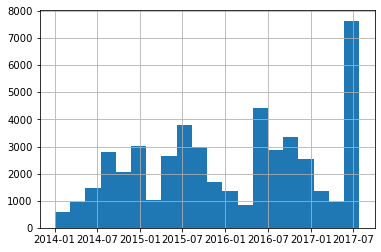

In [54]:
_ = posted_nan_funded.hist(bins=20)

The loans posted in the last month of the dataset, 2017-7, tended to lost funded time info.

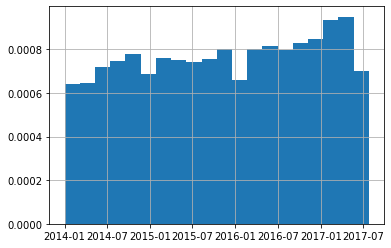

In [55]:
posted = times.posted_time.apply(lambda x: dt.strptime(x, '%Y-%m-%d'))
_ = posted.hist(bins=20, density=True)

During the time period of the dataset, the loans posted on the platform were distributed evenly.

#### `term_in_months` ,  `lender_count` and `repayment_interval` : No missing values
* `term_in_months`: The duration for which the loan was disbursed in months

* `lender_count`: The total number of lenders that contributed to this loan

* `repayment_interval`: No description

In [56]:
loans.term_in_months.describe()

count    671205.000000
mean         13.739022
std           8.598919
min           1.000000
25%           8.000000
50%          13.000000
75%          14.000000
max         158.000000
Name: term_in_months, dtype: float64

In [57]:
loans.lender_count.describe()

count    671205.000000
mean         20.590922
std          28.459551
min           0.000000
25%           7.000000
50%          13.000000
75%          24.000000
max        2986.000000
Name: lender_count, dtype: float64

In [58]:
loans.repayment_interval.value_counts()

monthly      342717
irregular    257158
bullet        70728
weekly          602
Name: repayment_interval, dtype: int64

#### `borrower_genders` (Gender inequality has big impact on poverty)
* `borrower_genders`: Comma separated M,F letters, where each instance represents a single male/female in the group

In [59]:
loans.borrower_genders.isna().sum()

4221

In [61]:
loans.borrower_genders.value_counts()

female                                                                                                                          426502
male                                                                                                                            134710
female, female                                                                                                                   12164
female, female, female                                                                                                           11676
female, female, female, female                                                                                                    9052
                                                                                                                                 ...  
female, male, female, female, female, male, female, female, female, male, male, female                                               1
male, male, female, female, female, male, female, femal

In [62]:
loans.borrower_genders.value_counts().head(10)

female                                                                            426502
male                                                                              134710
female, female                                                                     12164
female, female, female                                                             11676
female, female, female, female                                                      9052
female, female, female, female, female                                              7568
female, female, female, female, female, female                                      2674
female, female, female, female, female, female, female, female, female, female      2185
female, female, female, female, female, female, female                              2127
female, female, female, female, female, female, female, female                      1936
Name: borrower_genders, dtype: int64

Female borrowers make up the majority

#### `tags`(Keep just in case)

In [63]:
loans.tags.isna().sum()

171416

In [64]:
loans.tags.value_counts()

user_favorite                                                                            27088
#Parent, #Woman Owned Biz                                                                16597
#Woman Owned Biz                                                                         12557
#Parent                                                                                  11671
#Elderly                                                                                  6482
                                                                                         ...  
#Elderly, #Health and Sanitation, #Widowed, #Repeat Borrower, #Supporting Family             1
#Vegan, #Woman Owned Biz, #Schooling, user_favorite                                          1
volunteer_pick, #Animals, #Low-profit FP, #Job Creator                                       1
#Repeat Borrower, #Woman Owned Biz, #Woman Owned Biz, user_favorite, user_favorite           1
user_favorite, user_favorite, user_favorite, user_

In [65]:
loans.tags.value_counts().head(10)

user_favorite                                         27088
#Parent, #Woman Owned Biz                             16597
#Woman Owned Biz                                      12557
#Parent                                               11671
#Elderly                                               6482
#Eco-friendly, #Health and Sanitation, #Technology     5887
#Animals                                               5610
user_favorite, user_favorite                           5594
#Repeat Borrower                                       4627
#Woman Owned Biz, #Parent                              4305
Name: tags, dtype: int64

Some tags seems be duplicated, such as `user_favorite` and `user_favorite, user_favorite`, `#Parent, #Woman Owned Biz` and `#Woman Owned Biz, #Parent`, which should be aligned if necessary. But for now , I just fill the missing values
with 'Normal' to separate the loans with or without tags.

In [110]:
loans[loans.tags.notnull()].tags.str.contains('Normal').sum()

0

In [134]:
loans.tags.fillna('Normal', inplace=True)

In [135]:
loans.tags.unique()

array(['Normal', 'user_favorite, user_favorite',
       '#Elderly, #Woman Owned Biz', ...,
       'user_favorite, #Biz Durable Asset, #Single, #Trees, #Vegan',
       'user_favorite, user_favorite, #Parent, #Repair Renew Replace, #Vegan, user_favorite, user_favorite',
       'user_favorite, #Parent, #Biz Durable Asset, #Vegan, user_favorite'],
      dtype=object)

So for the `loans` dataset:
* The columns of `use`, `country_code`, `currency`, `disbursed_time`, and `date`, are removed 
* `ISO` with three-letter country code is added
* `tags` and `funded_time` are kept just in case; The missing values of `tags` are filled with 'Normal'
* The missing values of `region` need careful handling

In [136]:
# Remove country_code column and add ISO column
loans_1 = loans.drop(['use','country_code','currency','disbursed_time','date'], axis=1)
loans_1['ISO'] = loans_ISO_2_3.ISO.copy()
loans_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  671205 non-null  int64  
 1   funded_amount       671205 non-null  float64
 2   loan_amount         671205 non-null  float64
 3   activity            671205 non-null  object 
 4   sector              671205 non-null  object 
 5   country             671205 non-null  object 
 6   region              614405 non-null  object 
 7   partner_id          657698 non-null  float64
 8   posted_time         671205 non-null  object 
 9   funded_time         622874 non-null  object 
 10  term_in_months      671205 non-null  float64
 11  lender_count        671205 non-null  int64  
 12  tags                671205 non-null  object 
 13  borrower_genders    666984 non-null  object 
 14  repayment_interval  671205 non-null  object 
 15  ISO                 671205 non-nul

### MPI(multidimensional poverty index) by the location of region

In [34]:
mpi_region_locations = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/KivaData/kiva_mpi_region_locations.csv')

In [35]:
mpi_region_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LocationName  984 non-null    object 
 1   ISO           1008 non-null   object 
 2   country       1008 non-null   object 
 3   region        984 non-null    object 
 4   world_region  1008 non-null   object 
 5   MPI           984 non-null    float64
 6   geo           2772 non-null   object 
 7   lat           892 non-null    float64
 8   lon           892 non-null    float64
dtypes: float64(3), object(6)
memory usage: 195.0+ KB


Column descriptions:

0.LocationName: region, country

4.world_region: parts of the world

5.MPI: multidimensional poverty index

6.geo: (latitude, longitude)

7.lat: latitude

8.lon: longitude

In [36]:
# Check missing values
def missing_vals(data_):
    miss_     = data_.isnull().sum()
    miss_pct  = data_.isnull().sum()/data_.shape[0]
    
    miss_pct  = pd.concat([miss_, miss_pct], axis =1)
    miss_pct.reset_index(inplace=True)
    miss_cols = miss_pct.rename(columns={'index':'Column Name', 0:'Missings', 1:'Missing_pct'})
    
    miss_cols = miss_cols[miss_cols.iloc[:,1]!=0].sort_values('Missing_pct', ascending=False).round(2)
    miss_cols.reset_index(inplace=True, drop=True)
    
    return miss_cols

miss = missing_vals(mpi_region_locations)
miss

,Column Name,Missings,Missing_pct
0,lat,1880,0.68
1,lon,1880,0.68
2,LocationName,1788,0.65
3,region,1788,0.65
4,MPI,1788,0.65
5,ISO,1764,0.64
6,country,1764,0.64
7,world_region,1764,0.64


It looks wild that all the factors except `geo` have very high missing value rate.

In [68]:
mpi_region_locations.head()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


In [6]:
mpi_region_locations.tail()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
2767,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
2768,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
2769,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
2770,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
2771,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN


In [11]:
mpi_region_locations.country.last_valid_index()

1007

In [37]:
# Check the dataframe after the 1007th row
mpi_region_locations_1008 = mpi_region_locations.iloc[1008:, :]
mpi_region_locations_1008

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
1008,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
1009,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
1010,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
1011,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
1012,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
...,...,...,...,...,...,...,...,...,...
2767,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
2768,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
2769,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
2770,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN


In [38]:
mpi_region_locations_1008.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 1008 to 2771
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LocationName  0 non-null      object 
 1   ISO           0 non-null      object 
 2   country       0 non-null      object 
 3   region        0 non-null      object 
 4   world_region  0 non-null      object 
 5   MPI           0 non-null      float64
 6   geo           1764 non-null   object 
 7   lat           0 non-null      float64
 8   lon           0 non-null      float64
dtypes: float64(3), object(6)
memory usage: 124.2+ KB


All the rows after the 1007th row are invalid, which will be dropped.

In [39]:
mpi_region_locations = mpi_region_locations[:1008]
mpi_region_locations

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210
...,...,...,...,...,...,...,...,...,...
1003,"Mashonaland West, Zimbabwe",ZWE,Zimbabwe,Mashonaland West,Sub-Saharan Africa,0.192,"(-17.4851029, 29.7889248)",-17.485103,29.788925
1004,"Masvingo, Zimbabwe",ZWE,Zimbabwe,Masvingo,Sub-Saharan Africa,0.174,"(-20.0791909, 30.8384093)",-20.079191,30.838409
1005,"Matabeleland North, Zimbabwe",ZWE,Zimbabwe,Matabeleland North,Sub-Saharan Africa,0.238,"(-18.5331566, 27.5495846)",-18.533157,27.549585
1006,"Matabeleland South, Zimbabwe",ZWE,Zimbabwe,Matabeleland South,Sub-Saharan Africa,0.164,"(-21.052337, 29.0459927)",-21.052337,29.045993


In [40]:
mpi_region_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LocationName  984 non-null    object 
 1   ISO           1008 non-null   object 
 2   country       1008 non-null   object 
 3   region        984 non-null    object 
 4   world_region  1008 non-null   object 
 5   MPI           984 non-null    float64
 6   geo           1008 non-null   object 
 7   lat           892 non-null    float64
 8   lon           892 non-null    float64
dtypes: float64(3), object(6)
memory usage: 71.0+ KB


In [41]:
# Check the relationship between region and LocationName
mpi_region_locations[mpi_region_locations.LocationName.isna()].equals(mpi_region_locations[mpi_region_locations.region.isna()])

True

`LocationName` combines the `country` and `region` and the position of null values in `LocationName` and `region` are the same. So `LocationName` will be dropped.

In [27]:
# Check the relationship between region and MPI
mpi_region_locations[mpi_region_locations.MPI.isna()].equals(mpi_region_locations[mpi_region_locations.MPI.isna()])

True

It seems that the null values in `region` column and `MPI` column have the same patten.

* Compare the region info of `loans` dataset and `mpi_region_locations` dataset

In [31]:
loans.region.value_counts()

Kaduna                                     10000
Lahore                                      7178
Rawalpindi                                  4496
Cusco                                       3841
Dar es Salaam                               3719
                                           ...  
Stella Maris - Nkonkojeru                      1
Manganeng, Thaba Tseka                         1
Guarda La Lagunita, San Jose del Rincon        1
Kitaotao, Bukidnon                             1
Gyalto village, Aragatsotn region              1
Name: region, Length: 12695, dtype: int64

In [32]:
mpi_region_locations.region.value_counts()

Eastern       8
Central       8
Western       7
Nord          5
North         4
             ..
Cibao Sur     1
Manchester    1
As-swidaa     1
Bogota        1
Mzimba        1
Name: region, Length: 928, dtype: int64

It seems that they are very different

* Check `geo`, `lat` and `lon`

In [45]:
# Check the lat and lon's null values
(mpi_region_locations.lat.isna() == mpi_region_locations.lon.isna()).value_counts()

True    1008
dtype: int64

The missing values in `lat` and `lon` have the same patten.

In [47]:
mpi_region_locations[mpi_region_locations.lat.isna()]['geo']

34     (1000.0, 1000.0)
35     (1000.0, 1000.0)
36     (1000.0, 1000.0)
51     (1000.0, 1000.0)
63     (1000.0, 1000.0)
             ...       
958    (1000.0, 1000.0)
960    (1000.0, 1000.0)
965    (1000.0, 1000.0)
985    (1000.0, 1000.0)
987    (1000.0, 1000.0)
Name: geo, Length: 116, dtype: object

In [55]:
(mpi_region_locations.geo=='(1000.0, 1000.0)').sum()

116

In [57]:
mpi_region_locations[mpi_region_locations.lat.isna()].country.value_counts()

Honduras                                      8
Brazil                                        7
Gabon                                         7
Peru                                          5
Congo, Democratic Republic of the             4
                                             ..
Nicaragua                                     1
Guyana                                        1
Mexico                                        1
Macedonia, The former Yugoslav Republic of    1
Liberia                                       1
Name: country, Length: 67, dtype: int64

In [58]:
mpi_region_locations[mpi_region_locations.lat.isna()].region.value_counts()

Demerara-Mahaica             1
Ogoouð-Ivindo                1
Bouenza                      1
Labð                         1
Atlðntida                    1
                            ..
Apurðmac                     1
Manatuto                     1
Sharkia                      1
Jonglei and Unity            1
Valle Sin Cali Ni Litoral    1
Name: region, Length: 92, dtype: int64

The invalid `geo` values result in the missing values in `lat` and `lon` columns and seems distribute readomly

### Loan themes

In [69]:
loan_theme_ids = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/KivaData/loan_theme_ids.csv')

In [70]:
loan_theme_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779092 entries, 0 to 779091
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               779092 non-null  int64  
 1   Loan Theme ID    764279 non-null  object 
 2   Loan Theme Type  764279 non-null  object 
 3   Partner ID       764279 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 23.8+ MB


Column descriptions:

1.Loan Theme ID: Unique ID for loan theme

2.Loan Theme Type: General description of the loan theme category

3.Partner ID: Unique ID for field partners


In [71]:
loan_theme_ids.head(20)

,id,Loan Theme ID,Loan Theme Type,Partner ID
0,638631,a1050000000skGl,General,151.0
1,640322,a1050000000skGl,General,151.0
2,641006,a1050000002X1ij,Higher Education,160.0
3,641019,a1050000002X1ij,Higher Education,160.0
4,641594,a1050000002VbsW,Subsistence Agriculture,336.0
5,642256,a1050000000T3oX,Extreme Poverty,217.0
6,642311,a1050000000snTK,General,57.0
7,642353,a1050000000T3oX,Extreme Poverty,217.0
8,642386,a1050000000wf0f,General,133.0
9,642429,a1050000000wezJ,General,48.0


It seems that `Loan Theme ID` is unique to the pair of `Loan Theme Type` and `Partner ID`. For example, for the pair of 'General'(`Loan Theme Type`) and '151'(`Partner ID`), `Loan Theme ID` is 'a1050000000skGl', while for the pair of 'General'(`Loan Theme Type`) and '57'(`Partner ID`), `Loan Theme ID` is 'a1050000000snTK'.

### Loan themes by region

In [59]:
loan_themes_by_region = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/KivaData/loan_themes_by_region.csv')

In [60]:
loan_themes_by_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15736 entries, 0 to 15735
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Partner ID          15736 non-null  int64  
 1   Field Partner Name  15736 non-null  object 
 2   sector              15736 non-null  object 
 3   Loan Theme ID       15736 non-null  object 
 4   Loan Theme Type     15736 non-null  object 
 5   country             15736 non-null  object 
 6   forkiva             15736 non-null  object 
 7   region              15736 non-null  object 
 8   geocode_old         1200 non-null   object 
 9   ISO                 15722 non-null  object 
 10  number              15736 non-null  int64  
 11  amount              15736 non-null  int64  
 12  LocationName        15736 non-null  object 
 13  geocode             13662 non-null  object 
 14  names               13661 non-null  object 
 15  geo                 15736 non-null  object 
 16  lat 

In [61]:
loan_themes_by_region.head(10)

,Partner ID,Field Partner Name,sector,Loan Theme ID,Loan Theme Type,country,forkiva,region,geocode_old,ISO,...,amount,LocationName,geocode,names,geo,lat,lon,mpi_region,mpi_geo,rural_pct
0,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Banteay Meanchey,"(13.75, 103.0)",KHM,...,450,"Banteay Meanchey, Cambodia","[(13.6672596, 102.8975098)]",Banteay Meanchey Province; Cambodia,"(13.6672596, 102.8975098)",13.667260,102.897510,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
1,9,KREDIT Microfinance Institution,General Financial Inclusion,a10500000068jPe,Vulnerable Populations,Cambodia,No,Battambang Province,NaN,KHM,...,20275,"Battambang Province, Cambodia","[(13.0286971, 102.989615)]",Battambang Province; Cambodia,"(13.0286971, 102.989615)",13.028697,102.989615,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
2,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Battambang Province,NaN,KHM,...,9150,"Battambang Province, Cambodia","[(13.0286971, 102.989615)]",Battambang Province; Cambodia,"(13.0286971, 102.989615)",13.028697,102.989615,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
3,9,KREDIT Microfinance Institution,General Financial Inclusion,a10500000068jPe,Vulnerable Populations,Cambodia,No,Kampong Cham Province,"(12.0, 105.5)",KHM,...,604950,"Kampong Cham Province, Cambodia","[(12.0982918, 105.3131185)]",Kampong Cham Province; Cambodia,"(12.0982918, 105.3131185)",12.098292,105.313119,"Kampong Cham, Cambodia","(11.9924294, 105.4645408)",90.0
4,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000002X1Uu,Sanitation,Cambodia,No,Kampong Cham Province,"(12.0, 105.5)",KHM,...,275,"Kampong Cham Province, Cambodia","[(12.0982918, 105.3131185)]",Kampong Cham Province; Cambodia,"(12.0982918, 105.3131185)",12.098292,105.313119,"Kampong Cham, Cambodia","(11.9924294, 105.4645408)",90.0
5,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Kampong Cham Province,"(12.0, 105.5)",KHM,...,62225,"Kampong Cham Province, Cambodia","[(12.0982918, 105.3131185)]",Kampong Cham Province; Cambodia,"(12.0982918, 105.3131185)",12.098292,105.313119,"Kampong Cham, Cambodia","(11.9924294, 105.4645408)",90.0
6,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000007VvXr,Solar Home Systems,Cambodia,No,Kampong Cham Province,"(12.0, 105.5)",KHM,...,1300,"Kampong Cham Province, Cambodia","[(12.0982918, 105.3131185)]",Kampong Cham Province; Cambodia,"(12.0982918, 105.3131185)",12.098292,105.313119,"Kampong Cham, Cambodia","(11.9924294, 105.4645408)",90.0
7,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000weyk,General,Cambodia,No,Kampong Chhnang Province,"(12.0, 104.5)",KHM,...,237175,"Kampong Chhnang Province, Cambodia","[(12.1392352, 104.5655273)]",Kampong Chhnang Province; Cambodia,"(12.1392352, 104.5655273)",12.139235,104.565527,"Kampong Chhnang, Cambodia","(12.1392352, 104.5655273)",90.0
8,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000007VvXr,Solar Home Systems,Cambodia,No,Kampong Chhnang Province,"(12.0, 104.5)",KHM,...,3050,"Kampong Chhnang Province, Cambodia","[(12.1392352, 104.5655273)]",Kampong Chhnang Province; Cambodia,"(12.1392352, 104.5655273)",12.139235,104.565527,"Kampong Chhnang, Cambodia","(12.1392352, 104.5655273)",90.0
9,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Kampong Chhnang Province,"(12.0, 104.5)",KHM,...,31425,"Kampong Chhnang Province, Cambodia","[(12.1392352, 104.5655273)]",Kampong Chhnang Province; Cambodia,"(12.1392352, 104.5655273)",12.139235,104.565527,"Kampong Chhnang, Cambodia","(12.1392352, 104.5655273)",90.0


### Additional Data

In [75]:
MPI_national = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/AdditionalData/MPI_national.csv')

In [76]:
MPI_national.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ISO                             102 non-null    object 
 1   Country                         102 non-null    object 
 2   MPI Urban                       102 non-null    float64
 3   Headcount Ratio Urban           102 non-null    float64
 4   Intensity of Deprivation Urban  102 non-null    float64
 5   MPI Rural                       102 non-null    float64
 6   Headcount Ratio Rural           102 non-null    float64
 7   Intensity of Deprivation Rural  102 non-null    float64
dtypes: float64(6), object(2)
memory usage: 6.5+ KB


In [77]:
MPI_national.head()

,ISO,Country,MPI Urban,Headcount Ratio Urban,Intensity of Deprivation Urban,MPI Rural,Headcount Ratio Rural,Intensity of Deprivation Rural
0,KAZ,Kazakhstan,0.000,0.0,33.3,0.000,0.09,33.3
1,SRB,Serbia,0.000,0.1,41.4,0.002,0.50,40.3
2,KGZ,Kyrgyzstan,0.000,0.1,40.2,0.003,0.70,37.1
3,TUN,Tunisia,0.000,0.1,35.6,0.012,3.18,38.7
4,ARM,Armenia,0.001,0.2,33.3,0.001,0.39,36.9


In [78]:
MPI_subnational = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/AdditionalData/MPI_subnational.csv')

In [79]:
MPI_subnational.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ISO country code                   984 non-null    object 
 1   Country                            984 non-null    object 
 2   Sub-national region                984 non-null    object 
 3   World region                       984 non-null    object 
 4   MPI National                       984 non-null    float64
 5   MPI Regional                       984 non-null    float64
 6   Headcount Ratio Regional           984 non-null    float64
 7   Intensity of deprivation Regional  983 non-null    float64
dtypes: float64(4), object(4)
memory usage: 61.6+ KB


In [80]:
MPI_subnational.head()

,ISO country code,Country,Sub-national region,World region,MPI National,MPI Regional,Headcount Ratio Regional,Intensity of deprivation Regional
0,AFG,Afghanistan,Badakhshan,South Asia,0.295,0.387,67.5,57.3
1,AFG,Afghanistan,Badghis,South Asia,0.295,0.466,79.3,58.8
2,AFG,Afghanistan,Baghlan,South Asia,0.295,0.300,59.7,50.3
3,AFG,Afghanistan,Balkh,South Asia,0.295,0.301,55.7,54.1
4,AFG,Afghanistan,Bamyan,South Asia,0.295,0.325,61.0,53.3


In [81]:
World_population = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/AdditionalData/WorldPopulation.csv')

In [82]:
World_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         217 non-null    object 
 1   Country Code    217 non-null    object 
 2   Indicator Name  217 non-null    object 
 3   Indicator Code  217 non-null    object 
 4   1960            214 non-null    float64
 5   1961            214 non-null    float64
 6   1962            214 non-null    float64
 7   1963            214 non-null    float64
 8   1964            214 non-null    float64
 9   1965            214 non-null    float64
 10  1966            214 non-null    float64
 11  1967            214 non-null    float64
 12  1968            214 non-null    float64
 13  1969            214 non-null    float64
 14  1970            214 non-null    float64
 15  1971            214 non-null    float64
 16  1972            214 non-null    float64
 17  1973            214 non-null    flo

In [83]:
World_population.head()

,Country,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,Unnamed: 61
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281,NaN


In [84]:
HDI = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/AdditionalData/Human Development Index (HDI).csv', encoding = "ISO-8859-1")

In [85]:
HDI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 62 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HDI Rank     204 non-null    object 
 1   Country      206 non-null    object 
 2   1990         204 non-null    object 
 3   Unnamed: 3   0 non-null      float64
 4   1991         206 non-null    object 
 5   Unnamed: 5   0 non-null      float64
 6   1992         206 non-null    object 
 7   Unnamed: 7   0 non-null      float64
 8   1993         206 non-null    object 
 9   Unnamed: 9   0 non-null      float64
 10  1994         206 non-null    object 
 11  Unnamed: 11  0 non-null      float64
 12  1995         206 non-null    object 
 13  Unnamed: 13  0 non-null      float64
 14  1996         206 non-null    object 
 15  Unnamed: 15  0 non-null      float64
 16  1997         206 non-null    object 
 17  Unnamed: 17  0 non-null      float64
 18  1998         206 non-null    object 
 19  Unnamed:

In [86]:
HDI.head()

,HDI Rank,Country,1990,Unnamed: 3,1991,Unnamed: 5,1992,Unnamed: 7,1993,Unnamed: 9,...,2015,Unnamed: 53,2016,Unnamed: 55,2017,Unnamed: 57,2018,Unnamed: 59,2019,Unnamed: 61
0,169,Afghanistan,0.302,NaN,0.307,NaN,0.316,NaN,0.312,NaN,...,0.500,NaN,0.502,NaN,0.506,NaN,0.509,NaN,0.511,NaN
1,69,Albania,0.650,NaN,0.631,NaN,0.615,NaN,0.618,NaN,...,0.788,NaN,0.788,NaN,0.790,NaN,0.792,NaN,0.795,NaN
2,91,Algeria,0.572,NaN,0.576,NaN,0.582,NaN,0.586,NaN,...,0.740,NaN,0.743,NaN,0.745,NaN,0.746,NaN,0.748,NaN
3,36,Andorra,..,NaN,..,NaN,..,NaN,..,NaN,...,0.862,NaN,0.866,NaN,0.863,NaN,0.867,NaN,0.868,NaN
4,148,Angola,..,NaN,..,NaN,..,NaN,..,NaN,...,0.572,NaN,0.578,NaN,0.582,NaN,0.582,NaN,0.581,NaN


In [87]:
HDI = HDI.loc[:,~HDI.columns.str.match('Unnamed')]

In [88]:
HDI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   HDI Rank  204 non-null    object
 1   Country   206 non-null    object
 2   1990      204 non-null    object
 3   1991      206 non-null    object
 4   1992      206 non-null    object
 5   1993      206 non-null    object
 6   1994      206 non-null    object
 7   1995      206 non-null    object
 8   1996      206 non-null    object
 9   1997      206 non-null    object
 10  1998      206 non-null    object
 11  1999      206 non-null    object
 12  2000      206 non-null    object
 13  2001      206 non-null    object
 14  2002      206 non-null    object
 15  2003      206 non-null    object
 16  2004      206 non-null    object
 17  2005      206 non-null    object
 18  2006      206 non-null    object
 19  2007      206 non-null    object
 20  2008      206 non-null    object
 21  2009      206 no

In [89]:
HDI.head()

,HDI Rank,Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,169,Afghanistan,0.302,0.307,0.316,0.312,0.307,0.331,0.335,0.339,...,0.472,0.477,0.489,0.496,0.500,0.500,0.502,0.506,0.509,0.511
1,69,Albania,0.650,0.631,0.615,0.618,0.624,0.637,0.646,0.645,...,0.745,0.764,0.775,0.782,0.787,0.788,0.788,0.790,0.792,0.795
2,91,Algeria,0.572,0.576,0.582,0.586,0.590,0.595,0.602,0.611,...,0.721,0.728,0.728,0.729,0.736,0.740,0.743,0.745,0.746,0.748
3,36,Andorra,..,..,..,..,..,..,..,..,...,0.837,0.836,0.858,0.856,0.863,0.862,0.866,0.863,0.867,0.868
4,148,Angola,..,..,..,..,..,..,..,..,...,0.517,0.533,0.544,0.555,0.565,0.572,0.578,0.582,0.582,0.581


In [90]:
IHDI = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/AdditionalData/Inequality-adjusted HDI (IHDI).csv', encoding = "ISO-8859-1")

In [91]:
IHDI = IHDI.loc[:, ~IHDI.columns.str.match('Unnamed')]

In [92]:
IHDI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   HDI Rank  204 non-null    object
 1   Country   206 non-null    object
 2   2010      204 non-null    object
 3   2011      206 non-null    object
 4   2012      206 non-null    object
 5   2013      206 non-null    object
 6   2014      206 non-null    object
 7   2015      206 non-null    object
 8   2016      206 non-null    object
 9   2017      206 non-null    object
 10  2018      206 non-null    object
 11  2019      206 non-null    object
dtypes: object(12)
memory usage: 19.5+ KB


In [93]:
IHDI.head()

,HDI Rank,Country,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,169,Afghanistan,..,..,..,0.340,0.343,0.341,0.353,0.356,..,..
1,69,Albania,0.650,0.658,0.668,0.677,0.681,0.682,0.691,0.711,0.705,0.708
2,91,Algeria,..,..,..,..,..,..,..,0.591,0.594,0.596
3,148,Angola,0.311,..,0.305,0.311,0.356,0.361,0.391,0.394,0.397,0.397
4,46,Argentina,0.666,0.671,0.671,0.703,0.711,0.708,0.717,0.723,0.724,0.729
